<font color=red>**MIL SVM Notebook**</font>

<font color=red> **Team name: The WAY**</font>

<font color=red> **Students: Wassim BOUATAY - Amrou CHOUCHENE - Yassine NAJI**</font>

# Import libraries and Mount the drive

In [29]:
from google.colab import drive
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score ,accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import warnings 
from sklearn.metrics import confusion_matrix


warnings.simplefilter("ignore")


In [7]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data

In [8]:
path_data =  '/content/drive/My Drive/Challenge'
path_file = '/content/drive/My Drive/'
train_csv = pd.read_csv(path_data+"/trainset/trainset_true.csv")  
test_csv = pd.read_csv(path_data+"/testset/testset_data.csv")  
train_csv

,ID,LABEL,GENDER,DOB,LYMPH_COUNT
0,P26,1,M,11/3/1933,11.20
1,P183,1,M,5/15/1942,12.80
2,P89,1,M,6/19/1935,9.60
3,P123,1,M,1/27/1931,122.60
4,P61,1,F,3/5/1931,11.60
...,...,...,...,...,...
158,P135,1,M,27-08-1951,9.45
159,P8,0,M,16-05-1975,4.91
160,P130,0,F,16-05-1943,4.17
161,P70,1,M,05-09-1987,5.66


In [9]:
def csv_processing(features):
  def calculate_age(born):
    today = date.today()
    try:
      [day, month, year] = [int(i) for i in born.split("/")]
    except:
      [day, month, year] = [int(i) for i in born.split("-")]
    return today.year - year - ((today.month, today.day) < (month, day))

  features["DOB"] = features["DOB"].apply(calculate_age)
  features["GENDER"] = features["GENDER"].apply(lambda s:0 if s=='M' else 1)

  features["model_output"] = [0]*len(features)

  return features 

train_csv_preprocessed = csv_processing(train_csv)
test_csv_preprocessed = csv_processing(test_csv)

#### Load h5 files

In [11]:
f_train = h5py.File(path_file + '/train_data_h.h5', 'r')
f_val = h5py.File(path_file + '/val_data_h.h5', 'r')
f_test = h5py.File(path_file + '/test_data_h.h5', 'r')

### Split with stratification

In [12]:
aux_data = train_csv_preprocessed.copy(deep=True)

## Quantize age
dob_splits = list(aux_data['DOB'].sort_values()[0::len(aux_data)//2]) ## into 2 equal intervals
print("Age intervals:", dob_splits)
def Quantize_age(x):
  for i in range(1, len(dob_splits)):
    if x<dob_splits[i]:
      return i
  return len(dob_splits)-1
aux_data['DOB'] = aux_data['DOB'].apply(Quantize_age)

## Quantize Lymph_count
Lymph_splits = list(aux_data['LYMPH_COUNT'].sort_values()[0::len(aux_data)//2]) ## into 2 equal intervals
print("LYMPH_COUNT intervals:", Lymph_splits)
def Quantize_lymph(x):
  for i in range(1, len(Lymph_splits)):
    if x<Lymph_splits[i]:
      return i
  return len(Lymph_splits)-1
aux_data['LYMPH_COUNT'] = aux_data['LYMPH_COUNT'].apply(Quantize_lymph)

Age intervals: [22, 72, 99]
LYMPH_COUNT intervals: [2.28, 7.81, 295.0]


In [57]:
train_csv, val_csv = train_test_split(train_csv_preprocessed, 
                                      test_size=0.2, shuffle=True, 
                                      stratify=aux_data[['LABEL', 'GENDER', 'DOB', 'LYMPH_COUNT']])
print(len(train_csv), len(val_csv))
train_csv.head(7)

130 33


,ID,LABEL,GENDER,DOB,LYMPH_COUNT,model_output
151,P39,0,1,30,4.21,0
91,P180,1,0,62,39.60,0
69,P1,1,1,73,7.46,0
15,P27,1,1,68,130.00,0
46,P187,1,0,66,4.24,0
150,P3,0,1,23,5.20,0
96,P104,1,0,71,6.71,0


# MIL SVM

### load & process features 

In [18]:
# 8192 feature representation of images

# train_data = pd.read_csv(path_data + '/train_features_8192.csv')
# val_data = pd.read_csv(path_data + '/val_features_8192.csv')

# 4096 feature representation of segmented images

train_data = pd.read_csv(path_data + '/train_feature_4096.csv')
val_data = pd.read_csv(path_data + '/val_feature_4096.csv')


train_data = pd.concat([train_data, val_data])
print(train_data.shape)

(13508, 4100)


### PCA on features

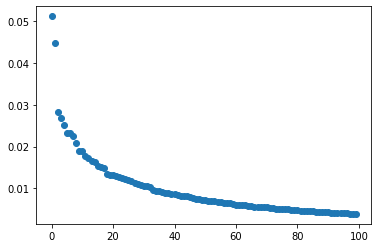

,ID_patient,pca_features_0,pca_features_1,pca_features_2,pca_features_3,pca_features_4,pca_features_5,pca_features_6,pca_features_7,pca_features_8,pca_features_9,pca_features_10,pca_features_11,pca_features_12,pca_features_13,pca_features_14,pca_features_15,pca_features_16,pca_features_17,pca_features_18,pca_features_19,pca_features_20,pca_features_21,pca_features_22,pca_features_23,pca_features_24,pca_features_25,pca_features_26,pca_features_27,pca_features_28,pca_features_29,pca_features_30,pca_features_31,pca_features_32,pca_features_33,pca_features_34,pca_features_35,pca_features_36,pca_features_37,pca_features_38,...,pca_features_60,pca_features_61,pca_features_62,pca_features_63,pca_features_64,pca_features_65,pca_features_66,pca_features_67,pca_features_68,pca_features_69,pca_features_70,pca_features_71,pca_features_72,pca_features_73,pca_features_74,pca_features_75,pca_features_76,pca_features_77,pca_features_78,pca_features_79,pca_features_80,pca_features_81,pca_features_82,pca_features_83,pca_features_84,pca_features_85,pca_features_86,pca_features_87,pca_features_88,pca_features_89,pca_features_90,pca_features_91,pca_features_92,pca_features_93,pca_features_94,pca_features_95,pca_features_96,pca_features_97,pca_features_98,pca_features_99
0,P0,-4.73438,13.3672,-7.40234,-0.640625,-4.60938,5.59375,-3.11328,12.1719,-5.26172,5.35156,-15.0859,-2.66406,11.6719,-7.71094,7.66797,2.63477,-5.69531,-6.42188,0.391357,1.67969,22.4531,7.75781,-2.90625,3.47852,-1.9707,4.46484,-8.52344,1.23145,-7.16797,-1.8125,-3.31836,2.67188,7.55859,0.524414,0.816895,3.78711,2.36914,0.412842,2.53125,...,-0.94043,5.85938,-5.93359,1.11914,-1.46191,0.508301,1.51074,0.00287437,-2.17969,-2.39844,0.941895,-2.17188,1.17578,4.48438,-3.48242,-2.5625,-0.996094,-0.751465,-4.67578,0.247803,-0.210083,0.529297,-0.294922,0.500488,-1.47949,-1.60547,3.96094,-3.79102,-2.08984,-0.975586,-1.30469,-1.19629,0.665527,0.023819,1.61523,0.800293,-1.33496,2.28906,1.2959,1.87109
1,P0,-5.55859,36.6562,16.7031,3.62695,-0.620605,10.7188,12.6406,2.27148,-14.9453,-12.3516,-12.8281,3.8457,5.14453,-0.241821,10.3438,-2.29492,14.25,13.5859,-9.72656,1.3457,4.06641,-8.33594,4.0625,-5.75391,4.09766,-2.67383,-3.69922,0.661133,6.75391,6.86328,-5.25391,2.05078,3.76953,-4.14844,-0.0750122,0.420166,12.8984,0.833496,2.93164,...,-8.46875,0.663574,2.11133,2.70312,-1.25098,-1.36816,-5.25391,3.25,2.04297,-0.190186,2.75,6.85938,5.73438,0.611816,-2.94336,-0.936035,0.4021,0.97168,-4.13672,1.38867,-4.30859,0.189697,4.10156,1.65527,-0.118896,1.24609,-0.63916,-0.491699,-3.21094,1.45215,2.41016,2.36914,-0.70166,-3.58398,6.77734,-0.397705,0.295166,-0.102478,1.17188,0.133423
2,P0,-7.97656,34.1875,12.1719,-0.124451,-0.907227,8.20312,4.76562,-3.81055,-7.10938,-6.41797,-9.76562,3.17383,-2.42383,-3.24023,-12.6328,-4.23438,-0.911621,-6.70703,1.27344,-6.55859,-10.8516,4.64062,-3.27148,2.64062,-1.49023,0.287109,0.0914917,-5.74609,4.53906,-7.28125,1.94922,-2.32617,3.75586,2.33789,-1.48438,0.619141,-4.38281,4.19141,6.69141,...,2.14648,2.72461,0.889648,-4.41406,-0.952148,0.0950928,-2.82422,2.19922,-0.19104,-1.5498,-0.112,0.44458,-0.230225,3.35547,-2.5625,0.910156,-3.3418,-1.52832,1.97461,-0.3125,-0.560547,-0.569824,0.654785,-1.53906,0.786133,-0.297852,-1.70117,-0.0181427,-1.56348,1.30273,-0.859863,0.655273,4.05078,0.65332,0.547363,1.47168,-3.45508,-0.494629,0.691895,3.52344
3,P0,-5.09375,5.11719,-16.5938,4.83594,0.540527,4.52344,0.504883,8.23438,0.57373,2.30273,2.09961,-7.58984,-1.4834,2.91016,4.01953,-4.09766,1.74414,-6.88672,9.05469,-4.6875,-1.19922,-2.45703,2.27539,2.11914,1.88867,4.55078,-6.85938,2.91211,-3.05273,-9.28125,3.88867,-0.768555,-0.537109,-0.904785,0.660645,-3.19922,1.10254,-5.22656,2.87891,...,-0.900391,4.82812,0.911133,2.61914,0.13147,-0.00479889,-0.808105,-1.60352,-0.0691528,-1.39258,-0.278076,-1.87109,2.34961,1.31836,0.267578,0.869141,-0.188232,0.567871,-0.37085,0.62207,-0.103333,1.56543,0.557129,1.88672,0.11499,-0.0768433,-0.660156,-1.99902,-0.664062,-2.1582,-0.79541,0.174072,0.812988,-1.33203,

In [19]:
nc = 100
pca = PCA(n_components=nc)
data = train_data[[f'image_features_{k}' for k in range(4096)]].values
scaler = StandardScaler() 
data = scaler.fit_transform(data)
aux_pca = pca.fit_transform(data)

# show singular values
plt.scatter(range(nc), pca.singular_values_/np.sum(pca.singular_values_))
plt.show()

aux = np.column_stack((train_data['ID_patient'], aux_pca.astype(np.float16)))
train_pca = pd.DataFrame(data = aux, columns = ['ID_patient']+[f'pca_features_{k}' for k in range(nc)])
train_pca.head(5)

### Preparing train and validation bags

In [79]:
# Train bags

bags_train = []
labels_train = []
train_patients = pd.unique(train_csv['ID'])

for patient in train_patients:

  # all features 
  #bag = train_data.groupby('ID_patient').get_group(patient)[[f'image_features_{k}' for k in range(4096)]].values.astype(np.float)

  # PCA features
  bag = train_pca.groupby('ID_patient').get_group(patient)[[f'pca_features_{k}' for k in range(nc)]].values.astype(np.float)

  bags_train.append(bag)
  target = int(train_csv[train_csv['ID'] == patient]['LABEL'].iloc[0])
  if target == 1:
    labels_train.append(1)
  elif target == 0 :
    labels_train.append(-1)
  else: 
    raise NameError('invalid target' ,target)

130 33


In [80]:
# validation bags

bags_val = []
labels_val = []
val_patients = pd.unique(val_csv['ID'])


for patient in val_patients:
  # all features 
  #bag = train_data.groupby('ID_patient').get_group(patient)[[f'image_features_{k}' for k in range(4096)]].values.astype(np.float)

  # PCA features
  bag = train_pca.groupby('ID_patient').get_group(patient)[[f'pca_features_{k}' for k in range(nc)]].values.astype(np.float)

  bags_val.append(bag)
  target = int(val_csv[val_csv['ID'] == patient]['LABEL'].iloc[0])
  if target == 1:
    labels_val.append(1)
  elif target == 0 :
    labels_val.append(-1)
  else: 
    raise NameError('invalid target' ,target)

### MI SVM

In [24]:
# Implementation of MIL SVM
! git clone https://github.com/garydoranjr/misvm
%cd /content/misvm
!python setup.py install
import misvm

Cloning into 'misvm'...
remote: Enumerating objects: 198, done.
remote: Total 198 (delta 0), reused 0 (delta 0), pack-reused 198
Receiving objects: 100% (198/198), 180.87 KiB | 4.02 MiB/s, done.
Resolving deltas: 100% (109/109), done.
/content/misvm
running install
running bdist_egg
running egg_info
creating misvm.egg-info
writing misvm.egg-info/PKG-INFO
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:125: UserWarning: newlines not allowed and will break in the future
  warnings.warn("newlines not allowed and will break in the future")
writing dependency_links to misvm.egg-info/dependency_links.txt
writing requirements to misvm.egg-info/requires.txt
writing top-level names to misvm.egg-info/top_level.txt
writing manifest file 'misvm.egg-info/SOURCES.txt'
writing manifest file 'misvm.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/misvm
copying misvm/sbmil.py

In [81]:
classifier = misvm.MISVM(kernel='linear', C=50, max_iters=20)

classifier.fit(bags_train, labels_train) 
labels_pred = classifier.predict(bags_val)

labels_pred = np.maximum(np.sign(labels_pred) , 0 )
labels_val = np.maximum(labels_val , 0 )
print("Validation Balanced accuracy={:.4f}%, \t Validation F1 score={:.4f}, \t Validation Recall={:.4f}, \t Validation Precision={:.4f}".format(balanced_accuracy_score(labels_val , labels_pred) , f1_score(labels_val , labels_pred) , recall_score(labels_val , labels_pred) , precision_score(labels_val , labels_pred)))

Non-random start...

Iteration 1...
Training SVM...
     pcost       dcost       gap    pres   dres
 0: -8.6465e+01 -1.2746e+01  7e+03  1e+02  2e-12
 1: -5.5710e+00 -1.2586e+01  1e+02  2e+00  1e-12
 2: -3.8458e+00 -8.3734e+00  1e+01  1e-01  1e-13
 3: -3.7099e+00 -5.6340e+00  3e+00  2e-02  6e-14
 4: -3.7014e+00 -4.2093e+00  5e-01  3e-03  6e-14
 5: -3.7033e+00 -3.7470e+00  4e-02  1e-04  7e-14
 6: -3.7037e+00 -3.7043e+00  6e-04  9e-07  8e-14
 7: -3.7037e+00 -3.7037e+00  6e-06  9e-09  8e-14
 8: -3.7037e+00 -3.7037e+00  6e-08  9e-11  8e-14
Optimal solution found.
Recomputing classes...
Selector differences: 2160
Updating QP...

Iteration 2...
Training SVM...
     pcost       dcost       gap    pres   dres
 0: -6.5950e+01 -1.2503e+01  7e+03  9e+01  6e-12
 1: -5.1380e+00 -1.2271e+01  2e+02  2e+00  7e-12
 2: -3.9314e+00 -9.0366e+00  5e+01  6e-01  2e-12
 3: -3.4213e+00 -6.1209e+00  2e+01  2e-01  7e-13
 4: -3.1336e+00 -4.3127e+00  1e+01  1e-01  4e-13
 5: -2.7057e+00 -3.8010e+00  9e+00  6e-02  3e

### Preparing data for XGBoost

In [89]:

final_train = pd.DataFrame()
y_train = []
final_val = pd.DataFrame()
y_val = []
final_test = pd.DataFrame()


for patient in train_patients:
  bag = train_pca.groupby('ID_patient').get_group(patient)[[f'pca_features_{k}' for k in range(nc)]].values.astype(np.float)
  pred = classifier.predict(bag)

  # label = np.max(pred)
  # label = np.mean(pred)
  label = len(pred[pred>0])/len(pred)

  age = int(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patient]['DOB'])
  LYMPH_COUNT = float(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patient]['LYMPH_COUNT'])
  
  dic = {'age':age, 'count':LYMPH_COUNT, 'label':label}
  final_train = final_train.append(dic,ignore_index=True)
  y_train.append(int(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patient]['LABEL']))

for patient in val_patients:
  bag = train_pca.groupby('ID_patient').get_group(patient)[[f'pca_features_{k}' for k in range(nc)]].values.astype(np.float)
  pred = classifier.predict(bag)

  # label = np.max(pred)
  # label = np.mean(pred)
  label = len(pred[pred>0])/len(pred)

  age = int(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patient]['DOB'])
  LYMPH_COUNT = float(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patient]['LYMPH_COUNT'])
  
  dic = {'age':age, 'count':LYMPH_COUNT, 'label':label}
  final_val = final_val.append(dic,ignore_index=True)
  y_val.append(int(train_csv_preprocessed.loc[train_csv_preprocessed["ID"]==patient]['LABEL']))

final_train = final_train.values
final_val = final_val.values


In [90]:
def plot_confusion_matrix(y_true, y_pred):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    classes = [0, 1]
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Normalized confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

[[0.7        0.3       ]
 [0.04347826 0.95652174]]
Validation Balanced accuracy=0.8283%, 	 Validation F1 score=0.9167, 	 Validation Recall=0.9565, 	 Validation Precision=0.8800


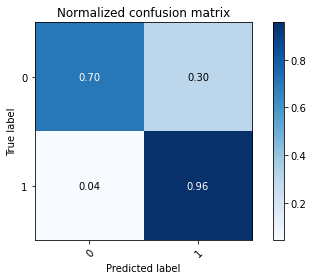

In [91]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100 ,scale_pos_weight=98/142)
xgb.fit(final_train, y_train)
y_pred = xgb.predict(final_val)
plot_confusion_matrix(y_val, y_pred)
print("Validation Balanced accuracy={:.4f}%, \t Validation F1 score={:.4f}, \t Validation Recall={:.4f}, \t Validation Precision={:.4f}".format(balanced_accuracy_score(y_val , y_pred) , f1_score(y_val , y_pred) , recall_score(y_val , y_pred) , precision_score(y_val , y_pred)))

### Submission

In [ ]:
test_ID = final_test["ID"]
final_test = final_test.drop(["ID"], axis=1)

output_file = open('kaggle.csv', "w")
output_file.write("ID,Predicted\n")

for idx in range(len(final_test)):
    pred = xgb.predict(final_test.iloc[idx])[0]
    output_file.write("%s,%d\n" % (test_ID[idx], pred))

output_file.close()
print("Succesfully wrote " + 'kaggle.csv' + ', you can upload this file to the kaggle competition website')